In [21]:
import tensorflow as tf
import numpy as np

import os
from pinn import PINNModel, model1
from accuracy import AccuracyCalc
from plotting import NNPlots
from data_gen import DataGenerator

In [22]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [23]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [24]:
area_grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 15000
EPRINT = 500
LOSS = 1e-4/4

# Define the learning rate schedule
boundaries = [5000, 10000, 50000]
values = [1e-3, 1e-4, 1e-5, 1e-6]

lr_sched = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

model = PINNModel(model1(4), optm = tf.keras.optimizers.Adam(learning_rate=lr_sched))

dataGen = DataGenerator(x_limits, y_limits, model.predict, real_u)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
koefs = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]
session_n = 3
for koef in koefs:
    path = f"../models/s{session_n}.model{koef}.weights.h5"
    if not os.path.exists(path):
        model.reset_weights()
        model.train(koef, dataGen.inner_pairs(area_grid_size), dataGen.border_pairs(border_grid_size), EPOCHS, LOSS, eprint=EPOCHS+1)
        model.save(path)

epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424
epoch: 0 loss: 116.645424


In [26]:
# for k in range(1, 10):
#     # model.reset_weights()
#     model.train(k, dataGen.inner_pairs(area_grid_size), dataGen.border_pairs(border_grid_size), EPOCHS, LOSS, EPRINT)
    
#     print("Error:", acc.mse())
#     print("Error:", acc.maxe())

#     model.save(f"../models/model{k}.weights.h5")

#     break

In [27]:
# Should be created after training model, because of predict in __init__
plotter = NNPlots(dataGen, (200, 200))
acc = AccuracyCalc(dataGen, (70, 70))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [31]:
print("Error:", acc.mse())
model.load_weights(f"../models/s{session_n}.model{3}.weights.h5")
acc = AccuracyCalc(dataGen, (70, 70))
print("Error:", acc.maxe())
session_n = 1

koefs_list = []
loss_record = []
for koef in koefs[:-2]:
    koefs_list.append(koef)
    model.load_weights(f"../models/s{session_n}.model{koef}.weights.h5")
    acc = AccuracyCalc(dataGen, (70, 70))
    print("Error:", acc.mse())
    loss_record.append(acc.mse())

Error: 0.059153308117541326
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
Error: 0.6396886706352234
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
Error: 0.0006692095021521003
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
Error: 0.0030932215823982244
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
Error: 0.0030817902587951924
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
Error: 0.0449153854036052
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
Error: 4.055526715300437e-06
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
Error: 2.9740875581815632e-05
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
Error: 3.2484587272747254e-05
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
Error: 0.003783568425728091
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
Error: 0.053675030019013754
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
Error: 0.05892007453189417
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
Error: 0.059153308117541326


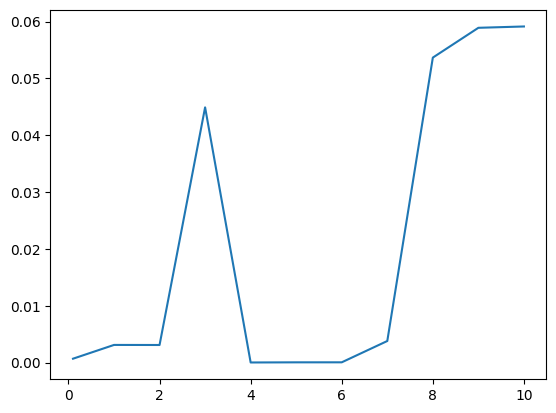

In [33]:
import matplotlib.pyplot as plt
plt.plot(koefs_list, loss_record)

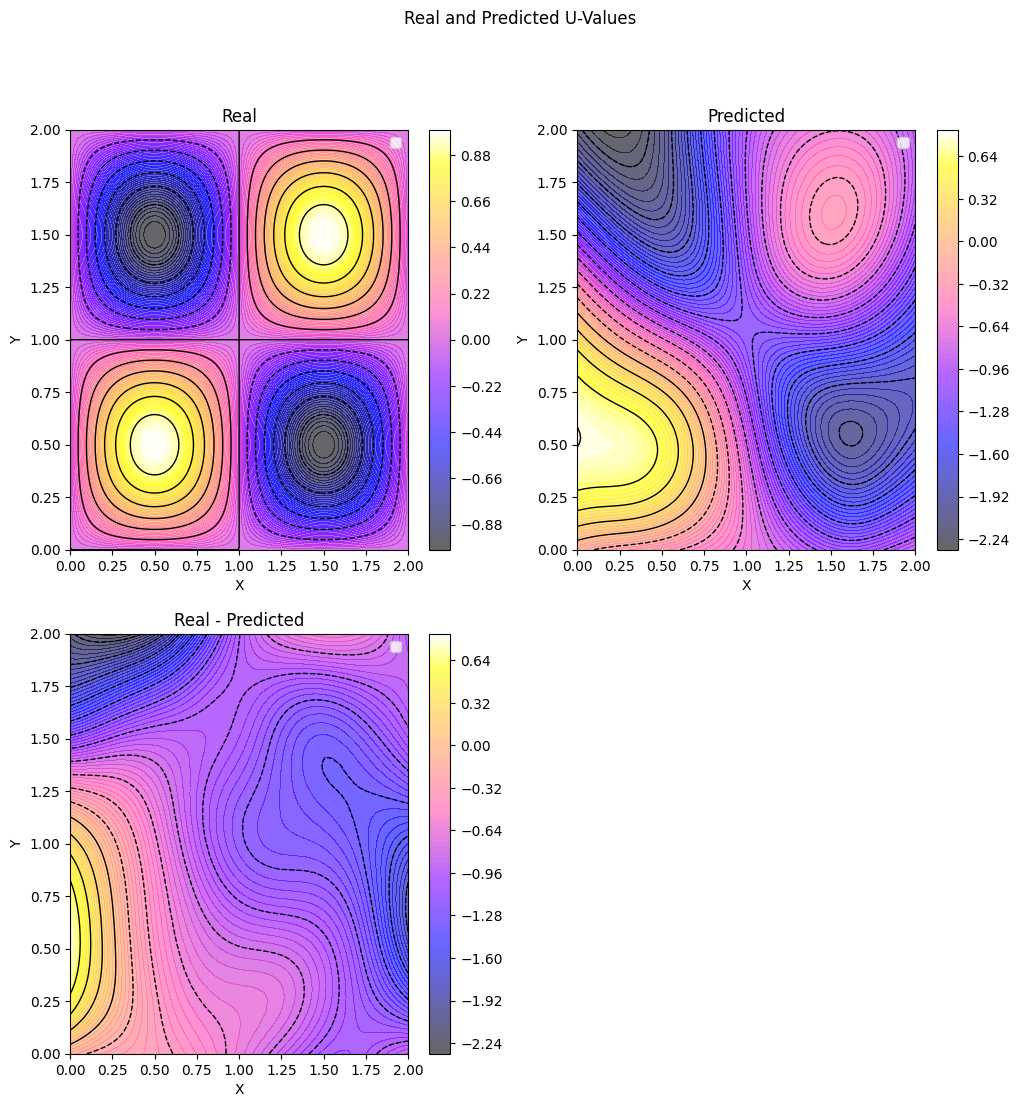

In [30]:
plotter.plot2d_contour(color_map="gnuplot2")